## Урок № 6. Градиентный бустинг (AdaBoost)

### Задание № 2*.
Модифицировать реализованный алгоритм, чтобы получился стохастический градиентный бустинг. Размер подвыборки принять равным 0.5. Сравнить на одном графике кривые изменения ошибки на тестовой выборке в зависимости от числа итераций.

In [3]:
from sklearn.tree import DecisionTreeRegressor

from sklearn import model_selection
import numpy as np

In [4]:
from sklearn.datasets import load_diabetes

In [5]:
X, y = load_diabetes(return_X_y=True)

In [6]:
X.shape, y.shape

((442, 10), (442,))

In [7]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

In [36]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((331, 10), (331,), (111, 10), (111,))

In [8]:
def gb_predict(X, trees_list, coef_list, eta):
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании прибавляются с шагом eta
    return np.array([sum([eta* coef * alg.predict([x])[0] for alg, coef in zip(trees_list, coef_list)]) for x in X])

In [9]:
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)

In [10]:
def bias(y, z):
    return (y - z)

In [11]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        # базовый алгоритм
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, coefs, eta)
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, bias(y_train, target))
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

**Реализация функционала стохастического градиентного спуска**

In [71]:
def sgb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        # базовый алгоритм
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на половине выборки X_train
            indexies = np.random.choice(X_train.shape[0], X_train.shape[0]//2, replace=False)
            tmp_X_train = [X[_] for _ in indexies].copy()
            tmp_y_train = [y[_] for _ in indexies].copy()
            target = gb_predict(tmp_X_train, trees, coefs, eta)
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(tmp_X_train, bias(tmp_y_train, target))
            mean_train_err = mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta))
            train_errors.append(mean_train_err)
            mean_test_err = mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta))
            test_errors.append(mean_test_err)
#             print(i)

        trees.append(tree)
#     print(test_errors)
    return trees, train_errors, test_errors

In [77]:
# Число деревьев в ансамбле
n_trees = 50

# для простоты примем коэффициенты равными 1
coefs = [1] * n_trees

# Максимальная глубина деревьев
max_depth = 3

# Шаг
eta = 0.1

In [78]:
gb_trees, gb_train_errors, gb_test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

In [79]:
sgb_trees, sgb_train_errors, sgb_test_errors = sgb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

In [14]:
def evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta):
    train_prediction = gb_predict(X_train, trees, coefs, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
с шагом {eta} на тренировочной выборке: {mean_squared_error(y_train, train_prediction)}')

    test_prediction = gb_predict(X_test, trees, coefs, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
с шагом {eta} на тестовой выборке: {mean_squared_error(y_test, test_prediction)}')

In [80]:
evaluate_alg(X_train, X_test, y_train, y_test, gb_trees, coefs, eta)

Ошибка алгоритма из 50 деревьев глубиной 3     с шагом 0.1 на тренировочной выборке: 1404.5551913184481
Ошибка алгоритма из 50 деревьев глубиной 3     с шагом 0.1 на тестовой выборке: 3685.6501937983226


In [81]:
evaluate_alg(X_train, X_test, y_train, y_test, sgb_trees, coefs, eta)

Ошибка алгоритма из 50 деревьев глубиной 3     с шагом 0.1 на тренировочной выборке: 1734.874490307394
Ошибка алгоритма из 50 деревьев глубиной 3     с шагом 0.1 на тестовой выборке: 2153.3802786374176


In [24]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [28]:
def get_error_plot(n_trees, gb_test_err, sgb_test_err):
    plt.xlabel('Iteration number')
    plt.ylabel('MSE')
    plt.xlim(0, n_trees+3)
    plt.plot(list(range(n_trees)), gb_test_err, label='gb_test_err')
    plt.plot(list(range(n_trees)), sgb_test_err, label='sgb_test_err')
    plt.legend(loc='upper right')
    plt.show()

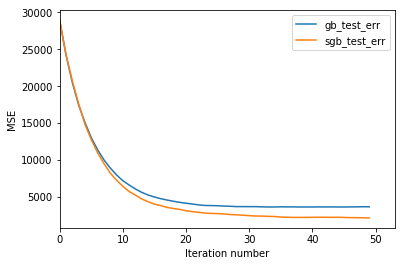

In [82]:
get_error_plot(n_trees, gb_test_errors, sgb_test_errors)

Неожиданно на тестовой выборке стохастический градиентный бустинг показывает результат лучше, чем обычный (если у меня корректно реализован алгоритм стохастического градиентного бустинга....)